In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import re
import os

In [79]:
file_path = 'all_house_data.csv'

#house_data = pd.read_csv('house_data.csv',index_col = 0)
house_data = pd.read_csv(file_path)

In [80]:
house_data.describe()

,Antal rum,Begärt pris,Biarea,Boarea,Byggår,Driftskostnad,Pris per kvadratmeter,Prisutveckling,Tomtarea,address,coordinate,id,map_url,price,sale_date,type,url,Avgift/månad,Förening
count,43183,33939,35995,42690,39118,35051,36897,39635,37919,43489,43491,43475,43440,43411,43344,42661,35576,19786,16804
unique,275,5861,1930,1921,5525,17401,19399,18411,22873,36223,38035,24067,1784,2549,3410,17629,28865,8685,6643
top,2 rum,Avgift/månad,Begärt pris,Boarea,1968,3 600 kr/år,\n,\n,\n,address,https://maps.googleapis.com/maps/api/js?librar...,https://maps.googleapis.com/maps/api/js?librar...,https://maps.googleapis.com/maps/api/js?librar...,bostadsratt,bostadsratt,bostadsratt,url,Biarea,Tomtarea
freq,10422,542,540,737,763,828,1029,2899,2001,470,2250,16563,23026,1395,10381,14332,470,309,362


In [4]:
regexp = re.compile('(\d+)')

def find_numbers(text):

    if pd.isnull(text):
        return text
    
    try:
        text_ = re.sub('m2','',text)
    except:
        return text
    
    try:
        results = regexp.findall(text_)
    except:
        return text_
    
    price_str = ''
    for result in results:
        price_str+=result
    
    try:
        price = float(price_str)
    except:
        price = None
    
    return price

In [5]:
date_regexp = re.compile('(\d\d\d\d-\d\d-\d\d)')
def find_date(date_string):
    if date_string is None:
        return None
    else:
        result = date_regexp.search(date_string)
        if result:
            return result.group(1)
        else:
            return None


In [6]:
col_names = ['Antal rum','Avgift/månad','Begärt pris','Boarea','Byggår','Driftskostnad','Pris per kvadratmeter','price','Tomtarea','Biarea']

for col_name in col_names:
    house_data[col_name] = house_data[col_name].apply(find_numbers)

In [7]:
mask = house_data['sale_date'].notnull()
house_data = house_data.loc[mask]

In [8]:
house_data['sale_date'] = pd.to_datetime(house_data['sale_date'].apply(func = find_date))



In [ ]:
fig,ax = plt.subplots()
house_data['price'].hist(bins = 40,ax = ax)

In [69]:
price_max = house_data['price'].quantile(0.90)
price_min = house_data['price'].quantile(0.1)

price_m2_max = house_data['Pris per kvadratmeter'].quantile(0.78)
price_m2_min = house_data['Pris per kvadratmeter'].quantile(0.09)


mask = ((house_data['price'] > price_min) & (house_data['price'] < price_max) &
       (house_data['Pris per kvadratmeter'] > price_m2_min) & (house_data['Pris per kvadratmeter'] < price_m2_max)
       )
house_data_clean = house_data.loc[mask].copy()

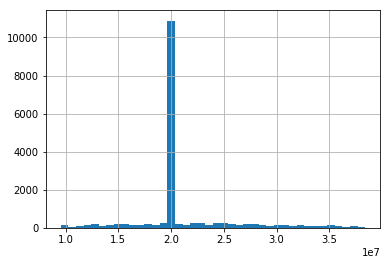

In [70]:
fig,ax = plt.subplots()
house_data_clean['price'].hist(bins = 40,ax = ax)

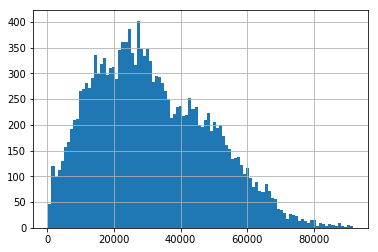

In [71]:
fig,ax = plt.subplots()
house_data_clean['Pris per kvadratmeter'].hist(bins = 100,ax = ax)

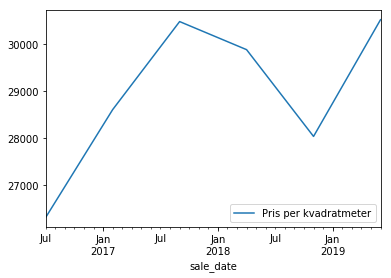

In [72]:
fig,ax = plt.subplots()
#mask = house_data['Pris per kvadratmeter'] < 70000
house_data_ = house_data_clean.set_index('sale_date')

house_data_.resample('7M').median().plot(y = 'Pris per kvadratmeter',ax = ax,alpha=1)

In [73]:
regexp_coordinates = re.compile('\[(.*)\,(.*)\]')
def get_lat_lon(coordinate_string):

    result = regexp_coordinates.search(coordinate_string)
    if not result:
        lat = None
        lon = None
    else:
        lat = float(result.group(1))
        lon = float(result.group(2))

    s = pd.Series()
    s['lat'] = lat
    s['lon'] = lon

    return s

In [74]:
coordinates = house_data_clean['coordinate'].apply(func = get_lat_lon)
house_data_clean = pd.concat((house_data_clean,coordinates),axis = 1)

In [75]:
mask = (house_data_clean['lat'].notnull() & house_data_clean['lon'].notnull())
house_data_clean = house_data_clean.loc[mask]

In [76]:
name,ext = os.path.splitext(file_path)
new_name = '%s_clean%s' % (name,ext)

In [77]:
house_data_clean.to_csv(new_name,index = False)